In [1]:
import pandas as pd

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
from pyspark.sql.functions import to_date, col, date_format
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
import matplotlib.pyplot as plt
spark = SparkSession \
    .builder \
    .master('local[*]') \
    .config("spark.driver.memory", "14g") \
    .appName('my-cool-app') \
    .getOrCreate()

sc=spark.sparkContext

23/02/10 05:10:31 WARN Utils: Your hostname, abdi-VivoBook-ASUSLaptop-X415EP-R465EP resolves to a loopback address: 127.0.1.1; using 172.27.172.43 instead (on interface wlo1)
23/02/10 05:10:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/10 05:10:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
schema = StructType([ \
        StructField("DEVICE_CODE", StringType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",StringType(),True), \
        StructField("FINAL_CAR_KEY",StringType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

In [4]:
df=spark.read.csv('SampleData_Week.csv',header=True,schema=schema)
df.show(1)

23/02/10 05:10:40 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 7
CSV file: file:///home/abdi/BigData/Project/SampleData_Week.csv/part-00000-599626a3-cb9d-4bee-90d4-36717bb81118-c000.csv
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22009851|      181|       33884851|     33884851|               6|       161|2022-01-01 14:52:59|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [5]:
# in this part we are adding day_of week column and also we want to 
# make a key for each camera and divide each day into 4 part
# so we are dividing hour to 6 and multiplying day with 4 and then adding them together
df = df.withColumn('time_key', hour(df.PASS_DAY_TIME)/6 + (dayofweek(df.PASS_DAY_TIME)-1)*4)
df = df.withColumn('date', to_date(df.PASS_DAY_TIME))
df = df.withColumn("day_of_week", date_format(col("date"), "EEEE"))

In [6]:
df.show(1)

23/02/10 05:10:46 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 9, schema size: 7
CSV file: file:///home/abdi/BigData/Project/SampleData_Week.csv/part-00000-599626a3-cb9d-4bee-90d4-36717bb81118-c000.csv
+-----------+---------+---------------+-------------+----------------+----------+-------------------+------------------+----------+-----------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|          time_key|      date|day_of_week|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+------------------+----------+-----------+
|   22009851|      181|       33884851|     33884851|               6|       161|2022-01-01 14:52:59|26.333333333333332|2022-01-01|   Saturday|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+------------------+----------+-----------+
only 

In [7]:
df = df.select('DEVICE_CODE' ,'time_key' , 'day_of_week' , 'FINAL_CAR_KEY' )


In [8]:
# this function is for making time_key a integer to have every 6 hours of a day in one bucket
def make_int(x):
    num = x[1]//1
    return (x[0],num,x[2] ,x[3])

In [9]:
df = df.rdd.map(lambda x: make_int(x))


In [10]:
from operator import add
df = df.map(lambda x:((x[0] , x[1] , x[2]) , 1)).reduceByKey(add)

In [12]:
#here we are making dataframe to groupby for each camera_id
#so we have 28 data for each camera ( some of them are even less than 28 and they don't have any data in some days)
Traffic = df
Traffic = Traffic.map(lambda x : (x[0][0] , (x[0][1], x[0][2] , x[1])) )
Traffic = Traffic.groupByKey()
Traffic = Traffic.map(lambda x : (x[0],sorted(set(list(x[1])))))

In [17]:
candidate_camera = Traffic.take(5)[0]

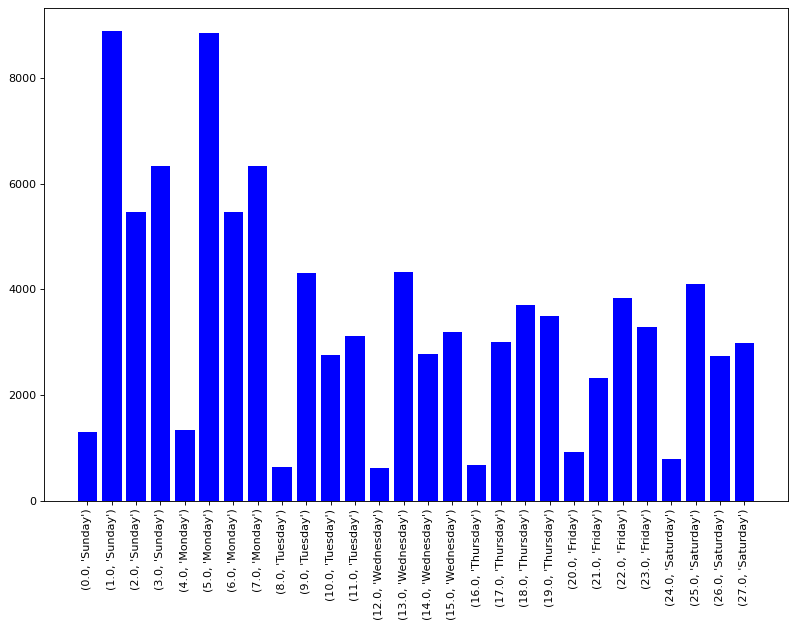

In [18]:
#now we want to plot histogram for camera '900247'
x_list = []
x_tick = []
y_list = []
for i , item in enumerate(candidate_camera[1]):
    x_list.append(i)
    x_tick.append((item[0] , item[1]))
    y_list.append(item[2])

plt.figure(figsize=(12, 8), dpi=80)
plt.bar(x_list, y_list, color='b')
plt.xticks(x_list, x_tick, rotation='vertical')
plt.show()

In [34]:
candidate_camera

('900247',
 [(0.0, 'Sunday', 1309),
  (1.0, 'Sunday', 8879),
  (2.0, 'Sunday', 5458),
  (3.0, 'Sunday', 6323),
  (4.0, 'Monday', 1345),
  (5.0, 'Monday', 8851),
  (6.0, 'Monday', 5468),
  (7.0, 'Monday', 6324),
  (8.0, 'Tuesday', 647),
  (9.0, 'Tuesday', 4315),
  (10.0, 'Tuesday', 2750),
  (11.0, 'Tuesday', 3112),
  (12.0, 'Wednesday', 628),
  (13.0, 'Wednesday', 4336),
  (14.0, 'Wednesday', 2773),
  (15.0, 'Wednesday', 3183),
  (16.0, 'Thursday', 671),
  (17.0, 'Thursday', 3004),
  (18.0, 'Thursday', 3705),
  (19.0, 'Thursday', 3489),
  (20.0, 'Friday', 920),
  (21.0, 'Friday', 2325),
  (22.0, 'Friday', 3836),
  (23.0, 'Friday', 3278),
  (24.0, 'Saturday', 783),
  (25.0, 'Saturday', 4098),
  (26.0, 'Saturday', 2742),
  (27.0, 'Saturday', 2982)])

In [192]:
import numpy as np
from numpy.linalg import norm
#calculating cos_similarity for our candid camera and all other cameras
def cos_sim(x):

    temp_vec = np.zeros(28)
    refrence = np.zeros(28)
    for i in range(28):
        
        temp_vec[i] = x[1][i][2]
        refrence [i]= candidate_camera[1][i][2]

    cos_sim_dist= np.dot(temp_vec, refrence)/(norm(temp_vec)*norm(refrence))

    return (x[0],(x[1] , cos_sim_dist))



In [193]:
import numpy as np
from numpy.linalg import norm

def Pearson_corr_coff(x):
    temp_vec = np.zeros(28)
    refrence = np.zeros(28)
    sum_temp = 0
    sum_ref = 0
    for i in range(28):
        
        temp_vec[i] = x[1][i][2]
        refrence [i]= candidate_camera[1][i][2]
        sum_temp += temp_vec[i]
        sum_ref += refrence[i]
    temp_ave = sum_temp / 28
    ref_ave = sum_ref / 28

    up_sum = 0
    down_sum_1 = 0
    down_sum_2 = 0
    for i in range(28):
        up_sum += (refrence[i] - ref_ave) * (temp_vec[i] - temp_ave)
        down_sum_1 += (refrence[i] - ref_ave) ** 2
        down_sum_2 += (temp_vec[i] - temp_ave) ** 2
    
    final_ans = up_sum/ ( (down_sum_1 ** (0.5)) * (down_sum_2 ** (0.5)) )
    
    return (x[0],(x[1] , final_ans))



In [199]:
temp_Traffic = Traffic
temp_Traffic = temp_Traffic.filter(lambda x : len(x[1]) == 28)

In [195]:
temp_Traffic = temp_Traffic.map(lambda x : cos_sim(x))


In [200]:
temp_Traffic = temp_Traffic.map(lambda x : Pearson_corr_coff(x))


In [201]:
temp_Traffic = temp_Traffic.sortBy(lambda x : -x[1][1])

In [197]:
#getting most similar cameras to our candid camera
#we set counter and we count all similar cameras until cosine similarity is under 0.98
# number of similar cameras is 86 and this is a good number
most_similar_to_candid = temp_Traffic.collect()
counter = 0
for item in most_similar_to_candid:
    if item[1][1] < 0.98:
        break
    counter += 1
print(counter)
most_similar_to_candid = most_similar_to_candid[1:counter]

86


In [204]:
#this part is for pearson_corr that we are taking first 40 camera
most_similar_to_candid = temp_Traffic.collect()
most_similar_to_candid = most_similar_to_candid[1:20]

In [205]:
#here we are predicting by getting weighted average of similar cameras

all_sum = 0
weight_sum = 0
for item in most_similar_to_candid:
    Friday_sec = item[1][0][21][2]
    all_sum += Friday_sec * item[1][1]
    weight_sum += item[1][1]

print("initialized value for camera with id {} for Friday 06:00 until 12:00 is {}".format('900247' , candidate_camera[1][21][2]))
print("predicted value for camera with id {} for Friday 06:00 until 12:00 is : {}".format('900247' , all_sum / weight_sum))
    

initialized value for camera with id 900247 for Friday 06:00 until 12:00 is 2325
predicted value for camera with id 900247 for Friday 06:00 until 12:00 is : 2752.1447739009886
